This is a script for building models for post-processing NWP visibility forecasts to produce calibrated ensemble forecasts using quantile regression forest applying the lead-time-continuous approach.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from quantile_forest import RandomForestQuantileRegressor
import numpy as np
import pickle
import time

/Users/clifflau/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Change paths for own use
data_path = "ROOT/preprocessed_data/"
model_export_path = "ROOT/trained_models/lead_time_continuous/"
result_export_path = "ROOT/test_results_df/lead_time_continuous/"

In [3]:
df_train = pd.read_csv(data_path + "df_training.csv", dtype={'time_in_day':'category'})
df_valid = pd.read_csv(data_path + "df_valid.csv", dtype={'time_in_day':'category'})
df_test = pd.read_csv(data_path + "df_test.csv", dtype={'time_in_day':'category'})
df_baseline = pd.read_csv(data_path + "df_training_baseline.csv", dtype={'time_in_day':'category'})

In [4]:
# Sample 10% of training records for faster training (comment out if necessary)
df_train = df_train.sample(frac=0.1, random_state=1)

In [10]:
# List of input features (using ensemble means and std for visibility foreasts)
features = ['lead_hr', 'station_alt', 'dis_from_coast', 'time_in_day', 'day_in_year_sin', 'day_in_year_cos',
                    't_ensemble_mean', 't_ensemble_std',
                    'q_ensemble_mean', 'q_ensemble_std',
                    'tp6_ensemble_mean', 'tp6_ensemble_std',
                    'tcc_ensemble_mean', 'tcc_ensemble_std',
                    'wind_ensemble_mean', 'wind_ensemble_std',
                    'vis_ensemble_mean', 'vis_ensemble_std']

x_train = df_train[features]
y_train = df_train['vis_obs']
#y_train = np.log(df_train['vis_obs']+0.00001) # Log transformation (uncomment for transformation of output)

x_valid = df_valid[features]
#y_valid = df_valid['vis_obs']+0.00001 # Log transformation (uncomment for transformation of output)

x_test = df_test[features]
#y_test = df_test['vis_obs']+0.00001 # Log transformation (uncomment for transformation of output)

# One-hot encode categorical 'time_in_day'
x_train = x_train.join(pd.get_dummies(x_train['time_in_day']))
x_train = x_train.drop('time_in_day',axis=1)
x_valid = x_valid.join(pd.get_dummies(x_valid['time_in_day']))
x_valid = x_valid.drop('time_in_day',axis=1)
x_test = x_test.join(pd.get_dummies(x_test['time_in_day']))
x_test = x_test.drop('time_in_day',axis=1)

In [11]:
x_train.shape, x_valid.shape, x_test.shape

((615077, 21), (650999, 21), (647208, 21))

In [12]:
x_train.columns

Index(['lead_hr', 'station_alt', 'dis_from_coast', 'day_in_year_sin',
       'day_in_year_cos', 't_ensemble_mean', 't_ensemble_std',
       'q_ensemble_mean', 'q_ensemble_std', 'tp6_ensemble_mean',
       'tp6_ensemble_std', 'tcc_ensemble_mean', 'tcc_ensemble_std',
       'wind_ensemble_mean', 'wind_ensemble_std', 'vis_ensemble_mean',
       'vis_ensemble_std', '06', '12', '18', '00'],
      dtype='object')

In [15]:
st = time.time()

rf = RandomForestQuantileRegressor(n_estimators=300, max_depth=20, random_state=18)
rf.fit(x_train, y_train)

# Save the model
with open(model_export_path + 'giant_300_20_quantile.pkl','wb') as f:
    pickle.dump(rf,f)

#y_pred_valid_rf = rf.predict(x_valid, quantiles=[0.5])
y_pred_valid_rf = np.exp(rf.predict(x_valid, quantiles=[0.5])) # Log transformation  (uncomment for transformation of output)
valid_error_rf = np.array(y_valid) - y_pred_valid_rf

valid_rmse_rf = np.sqrt(np.mean(valid_error_rf**2))
        
et = time.time()
elapsed_time = et - st

print("Validation RMSE: %s (execution time: %s s)"%(valid_rmse_rf, elapsed_time))

/Users/clifflau/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


Validation RMSE: 17236.786612588683 (execution time: 3274.3774993419647 s)


In [13]:
# Open previously trained model
#with open(model_path + 'giant_300_20_quantile_log.pkl', 'rb') as f:
    #rf = pickle.load(f)

Text(0.5, 1.0, 'Features Importances from RF')

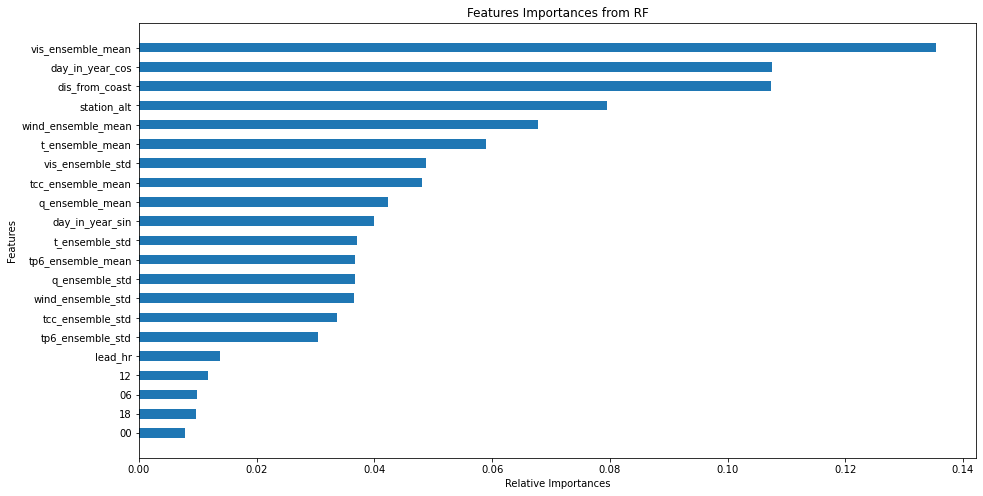

In [14]:
# Feature importance
plt.figure(figsize=(15,8))
importances = rf.feature_importances_
features = x_train.columns
indices = np.argsort(importances)
plt.barh(np.arange(len(features)), importances[indices], height=0.5)
plt.yticks(np.arange(len(features)), features[indices])
plt.ylabel("Features")
plt.xlabel("Relative Importances")
plt.title("Features Importances from RF")

In [15]:
# Test errors of NWP forecasts (before post-processing)
test_error_forecast = np.array(y_test)-np.array(df_test['vis_ensemble_mean'])

In [21]:
# Post-processed forecasts
quantile_candidates = [0.05 , 0.068, 0.086, 0.104, 0.122, 0.14 , 0.158, 0.176, 0.194,
       0.212, 0.23 , 0.248, 0.266, 0.284, 0.302, 0.32 , 0.338, 0.356,
       0.374, 0.392, 0.41 , 0.428, 0.446, 0.464, 0.482, 0.5  , 0.518,
       0.536, 0.554, 0.572, 0.59 , 0.608, 0.626, 0.644, 0.662, 0.68 ,
       0.698, 0.716, 0.734, 0.752, 0.77 , 0.788, 0.806, 0.824, 0.842,
       0.86 , 0.878, 0.896, 0.914, 0.932, 0.95]
y_pred_test_rf = rf.predict(x_test, quantiles=quantile_candidates)
#y_pred_test_rf = np.exp(rf.predict(x_test, quantiles=quantile_candidates)) # log transformation (uncomment for transformation of output)

/Users/clifflau/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


'y_pred_test_rf = np.exp(rf.predict(x_test, quantiles=quantile_candidates))'

In [45]:
# Baseline forecasts modelling raw visibility observations
baseline_by_forecast_time = []
for i in ['00','06','12','18']:
    baseline_by_forecast_time.append(np.quantile(df_baseline[df_baseline['time_in_day']==i]['vis_obs'], quantile_candidates))

y_pred_test_baseline = []
for i in range(0,len(y_test)):
    if df_result_test['time_in_day'][i]=='00':
        y_pred_test_baseline.append(baseline_by_forecast_time[0])
    elif df_test['time_in_day'][i]=='06':
        y_pred_test_baseline.append(baseline_by_forecast_time[1])
    elif df_test['time_in_day'][i]=='12':
        y_pred_test_baseline.append(baseline_by_forecast_time[2])
    else:
        y_pred_test_baseline.append(baseline_by_forecast_time[3])
        
y_pred_test_baseline = np.array(y_pred_test_baseline)
                                
# Baseline model modelling transformed visibility observations (uncomment if necessary)
'''baseline_by_forecast_time = []
for i in ['00','06','12','18']:
    baseline_by_forecast_time.append(np.exp(np.mean(np.log(df_baseline[df_baseline['time_in_day']==i]['vis_obs']+0.00001))))

y_pred_test_baseline = np.array([0]*len(y_test))
for i in range(len(y_test)):
    if df_test['time_in_day'][i]=='00':
        y_pred_test_baseline[i] = baseline_by_forecast_time[0]
    elif df_test['time_in_day'][i]=='06':
        y_pred_test_baseline[i] = baseline_by_forecast_time[1]
    elif df_test['time_in_day'][i]=='12':
        y_pred_test_baseline[i] = baseline_by_forecast_time[2]
    elif df_test['time_in_day'][i]=='18':
        y_pred_test_baseline[i] = baseline_by_forecast_time[3]
        
test_error_baseline = np.array(y_test)-y_pred_test_baseline'''

"baseline_by_forecast_time = []\nfor i in ['00','06','12','18']:\n    baseline_by_forecast_time.append(np.exp(np.mean(np.log(df_baseline[df_baseline['time_in_day']==i]['vis_obs']+0.00001))))\n\ny_pred_test_baseline = np.array([0]*len(y_test))\nfor i in range(len(y_test)):\n    if df_test['time_in_day'][i]=='00':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[0]\n    elif df_test['time_in_day'][i]=='06':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[1]\n    elif df_test['time_in_day'][i]=='12':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[2]\n    elif df_test['time_in_day'][i]=='18':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[3]\n        \ntest_error_baseline = np.array(y_test)-y_pred_test_baseline"

In [28]:
# Create a dataframe for storing test results
df_result_test = df_test[['base', 'lead_hr', 'forecast_time', 'time_in_day', 'vis_obs']]
for q in range(0, y_pred_test_rf.shape[1]):
    df_result_test['vis_rf_'+str(q+1)] = y_pred_test_rf[:,q]
for q in range(0, y_pred_test_rf.shape[1]):
    df_result_test['baseline_'+str(q+1)] = y_pred_test_baseline[:,q]
df_result_test

<ipython-input-28-4760c72d1891>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_test['vis_rf_'+str(q+1)] = y_pred_test_rf[:,q]


,base,lead_hr,forecast_time,time_in_day,vis_obs,vis_rf_1,vis_rf_2,vis_rf_3,vis_rf_4,vis_rf_5,...,vis_rf_42,vis_rf_43,vis_rf_44,vis_rf_45,vis_rf_46,vis_rf_47,vis_rf_48,vis_rf_49,vis_rf_50,vis_rf_51
0,2018-01-01 00:00:00,6,2018-01-01 06:00:00,06,19000.0,8000.00,8000.000,8000.000,9000.00,9000.000,...,20000.000,20000.0,20000.000,20000.00,20000.00,21000.000,21000.0,25000.00,25000.0,25000.0
1,2018-01-02 00:00:00,6,2018-01-02 06:00:00,06,18000.0,4795.00,5000.000,6000.000,7000.00,8000.000,...,20000.000,20000.0,20000.000,20000.00,20000.00,20000.000,20000.0,22000.00,25000.0,25000.0
2,2018-01-03 00:00:00,6,2018-01-03 06:00:00,06,13000.0,5000.00,6000.000,6000.000,7000.00,8000.000,...,17000.000,18000.0,18000.000,19758.00,20000.00,20000.000,20000.0,20000.00,23000.0,25000.0
3,2018-01-04 00:00:00,6,2018-01-04 06:00:00,06,9000.0,5000.00,6000.000,7000.000,7096.00,8000.000,...,20000.000,20000.0,20000.000,20000.00,20000.00,20000.000,20000.0,20000.00,21000.0,25000.0
4,2018-01-05 00:00:00,6,2018-01-05 06:00:00,06,25000.0,8000.00,8332.000,9000.000,10000.00,10000.000,...,20000.000,20000.0,20000.000,20000.00,21000.00,21000.000,22000.0,24000.00,25000.0,25000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647203,2018-12-27,120,2019-01-01,00,6715.0,99.95,100.000,100.000,134.48,200.000,...,9000.000,10000.0,10000.000,10000.00,10140.00,12000.000,12000.0,14650.14,15000.0,17050.0
647204,2018-12-28,120,2019-01-02,00,15318.0,100.00,100.000,100.000,101.92,164.258,...,10000.000,10000.0,11679.264,12000.00,13000.00,15000.000,15000.0,18000.00,20000.0,25250.0
647205,2018-12-29,120,2019-01-03,00,33728.0,1190.00,1432.800,2328.400,2919.20,3447.800,...,20000.000,20000.0,23752.000,25000.00,25000.00,25180.128,30000.0,30000.00,30000.0,40000.0
647206,2018-12-30,120,2019-01-04,00,38492.0,300.00,700.000,871.400,1218.24,1895.600,...,19135.864,20000.0,20000.000,20000.00,20000.00,25000.000,25000.0,30000.00,30000.0,40000.0


In [47]:
df_result_test.to_csv(result_export_path + "results_giant_20_300_quantile.csv", index=False)
# File format: results_giant_[max_depth]_[n_estimators]_[model variations: optional].csv